### Tetraクラスの定義
下のブロックには四面体のクラス：Tetraが定義されている.

In [ ]:
class Tetra():
    def __init__(self, p0, p1, p2, p3, index):
        self.point = [p0, p1, p2, p3]
        self.isCreated = [0, 0, 0, 0]
        self.triangle = [[p1, p2, p3], [p0, p2, p3], [p0, p1, p3], [p0, p1, p2]]
        self.edge = [
                        [p0, p1],
                        [p0, p2],
                        [p0, p3],
                        [p1, p2],
                        [p1, p3],
                        [p2, p3]
                    ]
        self.circumcenter, self.circumradius = calcCircumsphere([p0, p1, p2, p3])
        self.index = index

### 関数の定義
下のブロックには, 以下の関数が定義されている.

- set2D ... 2次元配列（list）を集合（set）に変換する関数. 配列のままだと計算しづらい同値判定を実行するため, 集合に変換したい際に使う.
- isIntersect ... 受け取った辺と三角形が衝突しているか（交差検証）, RayCastによって検証する関数. 新しく生成した四面体における辺（または面）と, 既存の四面体における面（または辺）の交差判定に使う.
- isCollide ... 四面体（１つ）と, 四面体の集合（複数）が衝突しているかを検証する関数. 既存の四面体全てと, 新しく生成された四面体との衝突判定に使う.
- calcCircumsphere ... 受け取った四面体における, 外接球の半径と中心の座標を計算する関数.
- findTriangleIndex ... 受け取った四面体の中で, p0, p1, p2を頂点とする三角形を見つけ, その番号（0~3）を返す関数.



In [41]:
def set2D(seq):
    ## 2次元配列を集合に変換する関数.
    ## ref: https://qiita.com/uuuno/items/b714d84ca2edbf16ea19
    return set(map(tuple, seq))

def isIntersect (triangle, line):
    ## triangleとlineが交差しているかの判定を行う関数.
    ## line: [重心, 頂点]
    origin = np.array(line[0]) ## 線分の開始点
    ray = np.array(line[1]) ## 線分の終点
    invRay = -1 * ray ## 終点ベクトルの反対
    v0 = np.array(triangle[0])
    v1 = np.array(triangle[1])
    v2 = np.array(triangle[2])
    
    if len(set2D([v0, v1, v2]) & set2D([origin, ray])) == 0:
        
        edge1 = v1 - v0
        edge2 = v2 - v0

        denominator = LP.det([edge1, edge2, invRay])

        if denominator > 0 :
            d = origin - v0
            u = LP.det([d, edge2, invRay]) / denominator
            if 0 <= u <= 2.5: ## note: ここをいくつの値に設定するかで全体の形状に影響を与えそう.
                v = LP.det([edge1, d, invRay]) / denominator
                if 0 <= v and u + v <= 2.5: ## note: ここをいくつの値に設定するかで全体の形状に影響を与えそう.
                    t = LP.det([edge1, edge2, d]) / denominator

                    ## 距離がマイナスの場合は交差していない
                    if t >= 0 :
                        return True

        origin = np.array(line[1]) ## 線分の開始点
        ray = np.array(line[0]) ## 線分の終点
        invRay = -1 * ray ## 終点ベクトルの反対

        denominator = LP.det([edge1, edge2, invRay])

        if denominator > 0 :
            d = origin - v0
            u = LP.det([d, edge2, invRay]) / denominator
            if 0 <= u <= 2.5: ## note: ここをいくつの値に設定するかで全体の形状に影響を与えそう.
                v = LP.det([edge1, d, invRay]) / denominator
                if 0 <= v and u + v <= 2.5: ## note: ここをいくつの値に設定するかで全体の形状に影響を与えそう.
                    t = LP.det([edge1, edge2, d]) / denominator

                    ## 距離がマイナスの場合は交差していない
                    if t >= 0 :
                        return True
    
    return False

def isCollide (candidate_tetra, tetra_set):
    
    ## 衝突判定
    for j in reversed(range(0, len(tetra_set))):
        target_tetra = tetra_set[j]
        ## 外接球を用いた大まかな衝突判定
        if LP.norm(candidate_tetra.circumcenter-target_tetra.circumcenter) <= target_tetra.circumradius + candidate_tetra.circumradius:
            c_p = candidate_tetra.point
            ## 新規に作成される辺候補のリスト
            candidate_edges = [[c_p[0] ,c_p[3]], [c_p[1] ,c_p[3]], [c_p[2] ,c_p[3]]]

            ## 新規に作成される面候補のリスト
            candidate_triangles = [
                [c_p[0], c_p[1], c_p[3]],
                [c_p[0], c_p[2], c_p[3]],
                [c_p[1], c_p[2], c_p[3]]
            ]

            for k in range(4):
                for l in range(3):
                    ## 新しく生成される辺と既存の面が交差するかどうかの判定
                    if isIntersect(target_tetra.triangle[k], candidate_edges[l]):
                        return True

            for m in range(6):
                for n in range(3):
                    ## 新しく生成される面と既存の辺が交差するかどうかの判定
                    if isIntersect(candidate_triangles[n], target_tetra.edge[m]): 
                        return True
    return False

def calcCircumsphere(point):
    ### 外接球の半径と外点を求める関数
    p0 = np.array(point[0])
    p1 = np.array(point[1])
    p2 = np.array(point[2])
    p3 = np.array(point[3])
    matrix = [p0-p1, p0-p2, p2-p3]

    ### 外接円の外点
    circumcenter = 0.5 * np.dot(LP.inv(matrix) , [LP.norm(p0)**2-LP.norm(p1)**2, LP.norm(p0)**2-LP.norm(p2)**2, LP.norm(p2)**2-LP.norm(p3)**2])
    ### 外接円の半径
    circumradius = LP.norm(p0 - circumcenter)
    
    return circumcenter, circumradius

def findTriangleIndex(tetra, p0, p1, p2):
    ## tetraが持つ三角形のうち、p0, p1, p2からなる三角形に一致するものを返す関数.
    for index in range(0, 4):
        ## print(tetra.triangle[index])
        if len(set2D(tetra.triangle[index]) & set2D([p0, p1, p2])) == 3:
                return index
    
    ## 上のreturnが実行されなかった場合 = p0, p1, p2からなる三角形は存在しない
    print("error: there's no triangle in tetra: "+str([p0, p1, p2]))
    print("tetra's point: "+str(tetra.point))
    return -1

### 変数の定義
ここでユーザが自由に定義できる変数を設定.　変数は,
- num ... 生成したい四面体の個数.
- threshold ... merge処理を実行するとき, くっつける頂点の距離の閾値. 2つの頂点間の距離が, 閾値以下の場合に四面体同士がくっつく.

In [62]:
## 生成したい四面体の個数をここで指定:
num = 100
threshold = 30 ##くっつける頂点の距離の閾値. 2つの頂点間の距離が, 閾値以下の場合に四面体同士がくっつく.

### Main
ここで一連の計算が行われる.

In [63]:
import random
import copy
import numpy as np
import numpy.linalg as LP
import itertools
import time

####### MAIN #######
start = time.time()

print('generate '+str(num)+' tetrahedron.')

##最初の四面体を作成
tetra = Tetra([10 ,10 ,10], [-10,-10,10], [10,-10,-10], [-10, 10, -10], 0)

tetra_set = []

## 配列に追加
tetra_set.append(tetra)

while len(tetra_set) < num:
    for i in range(0, len(tetra_set)):
        ## i 番目の四面体情報を取得
        tetra_i = tetra_set[i]
        
        ## i 番目の四面体情報をもとに新しい四面体を作成
        ## 面を選ぶ
        target = random.randint(0, 3)
        
        if tetra_i.isCreated[target] == 0:
            s = tetra_i.triangle[target] ##tetra_i上のtarget番目の三角形.
            
            ## ベクトルを作る
            center = (np.array(s[0])+np.array(s[1])+np.array(s[2])) / 3 ## 三角形の重心
            left_point = np.array(tetra_i.point[target]) ## 三角形sに含まれないtetra_iの頂点
            vector = np.array(left_point - center) ##頂点-重心

            ## 頂点を作る
            k = random.uniform(0.7, 1.5) ##ベクトルに掛け合わされる定数
            c_p = list(map(int, -1 * k * vector + center)) ## candidate_point. 頂点候補（衝突判定によって棄却される可能性あり）
            ## print(c_p)
            
            candidate_tetra = Tetra(s[0], s[1], s[2], c_p, len(tetra_set))
            connected_tetra = None
                
            ## merge処理 開始
            merged = False

            for target_tetra in tetra_set:
                if merged:
                    break

                ## 共有する頂点の数を検出.
                ## 0 ... 四面体は接していない
                ## 1 ... 四面体は一点でのみ接する
                ## 2 ... 四面体は1辺を共有する
                ## 3 ... 四面体は1面を共有する
                if len(set2D(candidate_tetra.point) & set2D(target_tetra.point)) == 2: ## 1つの辺を共有する場合
                    candidate_point = candidate_tetra.point[3] ## 末尾の頂点.
                    ## くっつく可能性のある頂点 = 共有している辺以外の頂点２つ.　= 「candidate_tetraとtarget_tetraに共通しない要素」とtarget_tetraに共通する要素
                    target_points = list(map(list, (set2D(candidate_tetra.point) ^ set2D(target_tetra.point)) & set2D(target_tetra.point)))

                    ## 2つの四面体が共有する辺.
                    shared_edge = list(map(list, set2D(candidate_tetra.point) & set2D(target_tetra.point)))

                    ## 発生率はかなり低いが, 稀にcandidate_pointがshared_edgeに含まれる
                    ## =新規で作成された頂点が既存の他の頂点にたまたま一致することがある.
                    ## この場合は何もしないので、 それをハンドリング.
                    if not candidate_point in shared_edge:

                        for target_point in target_points:
                            ## print("target")
                            target_triangle_index = findTriangleIndex(target_tetra, shared_edge[0], shared_edge[1], target_point)
                            if target_tetra.isCreated[target_triangle_index] == 0: ##merge先になる可能性のある四面体におけるisCreatedのチェック.
                                if LP.norm(np.array(target_point)-np.array(candidate_point)) < threshold: ##閾値以下の場合
                                    candidate_triangle_index = findTriangleIndex(candidate_tetra, shared_edge[0], shared_edge[1], candidate_point)
                                    candidate_tetra.point[3] = target_point
                                    connected_tetra = target_tetra
                                    merged = True
                                    break

            ## merge処理 終了
                
            if not isCollide(candidate_tetra, tetra_set):
                ## 判定をPassした場合 :
                candidate_tetra.isCreated[3] = 1 ##生成した時点で接してる四面体
                tetra_set[i].isCreated[target] = 1

                if connected_tetra is not None:
                    if candidate_triangle_index != -1 and target_triangle_index != -1:
                        candidate_tetra.isCreated[candidate_triangle_index] = 1
                        tetra_set[connected_tetra.index].isCreated[target_triangle_index] = 1

                ## 一覧に追加
                new_tetra = Tetra(candidate_tetra.point[0], candidate_tetra.point[1], candidate_tetra.point[2], candidate_tetra.point[3], candidate_tetra.index)
                tetra_set.append(new_tetra)

                print("\r"+"processing...("+'{:.1f}'.format(len(tetra_set)/num*100)+"%)",end="")

            if(len(tetra_set) == num): break

elapsed_time = time.time() - start
print("\n"+"completed. ({:.4g}".format(elapsed_time) + "s)")

generate 100 tetrahedron.
processing...(100.0%)
completed. (3.595s)


In [66]:
## 生成された四面体の頂点情報の出力(Processingで出力可能)
c = 5 ## 出力時のスケール

for i in range(0, len(tetra_set)):
    tetra = tetra_set[i]
    for j in range(0, 4):
        print("beginShape();")
        s = tetra.triangle[j]
        for k in range(0, 3):
            print("vertex("+str(s[k][0]*c)+", "+str(s[k][1]*c)+", "+str(s[k][2]*c)+");")
        print("endShape();")
        print("\n")

beginShape();
vertex(-50, -50, 50);
vertex(50, -50, -50);
vertex(-50, 50, -50);
endShape();


beginShape();
vertex(50, 50, 50);
vertex(50, -50, -50);
vertex(-50, 50, -50);
endShape();


beginShape();
vertex(50, 50, 50);
vertex(-50, -50, 50);
vertex(-50, 50, -50);
endShape();


beginShape();
vertex(50, 50, 50);
vertex(-50, -50, 50);
vertex(50, -50, -50);
endShape();


beginShape();
vertex(50, -50, -50);
vertex(-50, 50, -50);
vertex(-85, -85, -85);
endShape();


beginShape();
vertex(-50, -50, 50);
vertex(-50, 50, -50);
vertex(-85, -85, -85);
endShape();


beginShape();
vertex(-50, -50, 50);
vertex(50, -50, -50);
vertex(-85, -85, -85);
endShape();


beginShape();
vertex(-50, -50, 50);
vertex(50, -50, -50);
vertex(-50, 50, -50);
endShape();


beginShape();
vertex(-50, 50, -50);
vertex(-85, -85, -85);
vertex(-155, -5, -5);
endShape();


beginShape();
vertex(-50, -50, 50);
vertex(-85, -85, -85);
vertex(-155, -5, -5);
endShape();


beginShape();
vertex(-50, -50, 50);
vertex(-50, 50, -50);
ver

vertex(0, 0, 165);
endShape();


beginShape();
vertex(50, 50, 50);
vertex(-50, -50, 50);
vertex(0, 0, 165);
endShape();


beginShape();
vertex(50, 50, 50);
vertex(-50, -50, 50);
vertex(75, -75, 75);
endShape();


beginShape();
vertex(-100, 100, 105);
vertex(-185, -25, 185);
vertex(0, 0, 165);
endShape();


beginShape();
vertex(-50, -50, 50);
vertex(-185, -25, 185);
vertex(0, 0, 165);
endShape();


beginShape();
vertex(-50, -50, 50);
vertex(-100, 100, 105);
vertex(0, 0, 165);
endShape();


beginShape();
vertex(-50, -50, 50);
vertex(-100, 100, 105);
vertex(-185, -25, 185);
endShape();


beginShape();
vertex(-50, 50, -50);
vertex(105, 65, -65);
vertex(50, -50, -50);
endShape();


beginShape();
vertex(50, 50, 50);
vertex(105, 65, -65);
vertex(50, -50, -50);
endShape();


beginShape();
vertex(50, 50, 50);
vertex(-50, 50, -50);
vertex(50, -50, -50);
endShape();


beginShape();
vertex(50, 50, 50);
vertex(-50, 50, -50);
vertex(105, 65, -65);
endShape();


beginShape();
vertex(-50, -50, 50);
ve

<class 'tuple'>


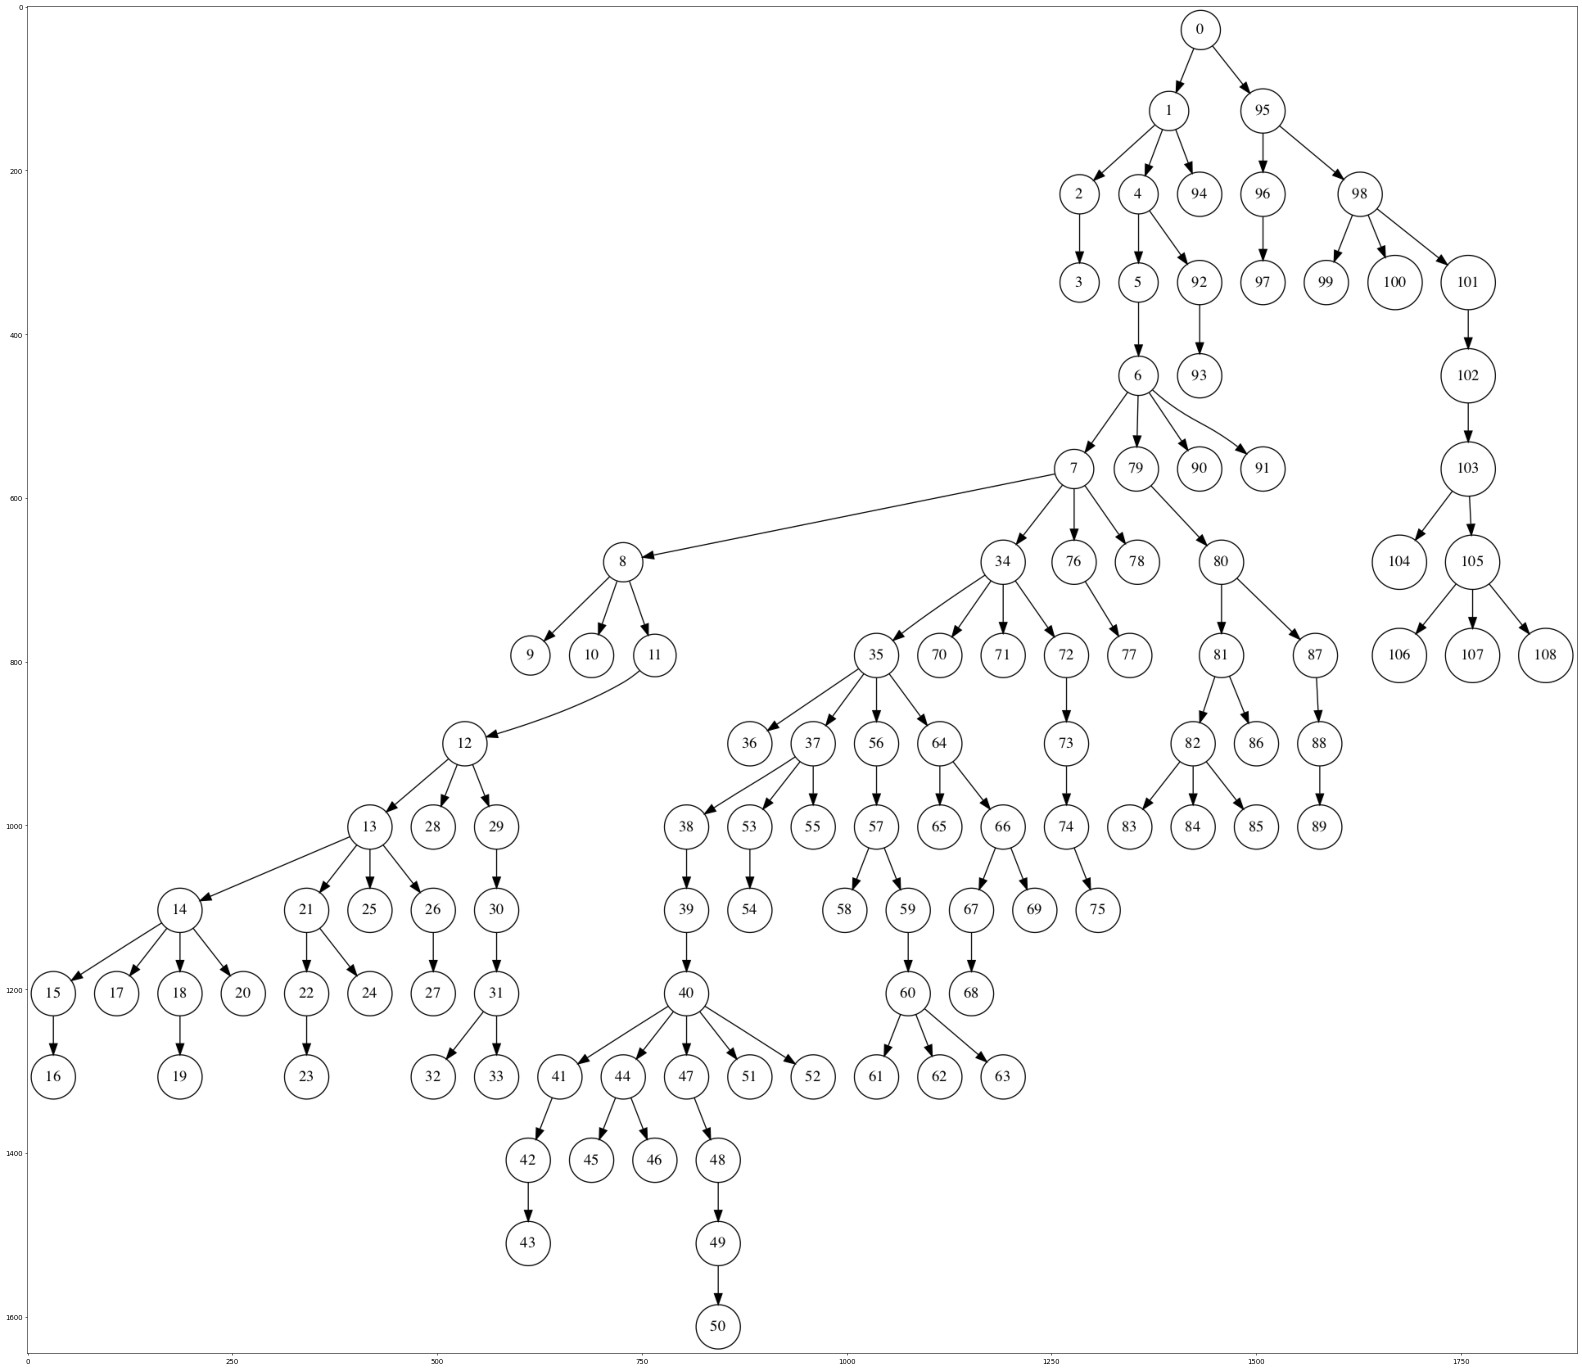

In [9]:
%matplotlib inline
 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from graphviz import Digraph

G = Digraph(format="png")
G.attr("node", shape="circle")
edges = [(0, 1), (0, 95), (1, 2), (1, 4), (1, 94), (2, 3), (4, 5), (4, 92), (5, 6),
(6, 7), (6, 79), (6, 90), (6, 91), (7, 8), (7, 34), (7, 76), (7, 78), (8, 9), (8, 10), (8, 11),
(11, 12), (12, 13), (12, 28), (12, 29), (13, 14), (13, 21), (13, 25), (13, 26), (14, 15), (14, 17), (14, 18), (14, 20),
(15, 16), (18, 19), (21, 22), (21, 24), (22, 23), (26, 27), (29, 30), (30, 31), (31, 32), (31, 33),
(34, 35), (34, 70), (34, 71), (34, 72), (35, 36), (35, 37), (35, 56), (35, 64), (37, 38), (37, 53), (37, 55),
(38, 39), (39, 40), (40, 41), (40, 44), (40, 47), (40, 51), (40, 52), (41, 42), (42, 43), (44, 45), (44, 46),
(47, 48), (48, 49), (49, 50), (53, 54), (56, 57), (57, 58), (57, 59), (59, 60), (60, 61), (60, 62), (60, 63),
(64, 65), (64, 66), (66, 67), (66, 69), (67, 68), (72, 73), (73, 74), (74, 75), (76, 77), (79, 80), (80, 81), (80, 87),
(81, 82), (81, 86), (82, 83), (82, 84), (82, 85), (87, 88), (88, 89), (92, 93), (95, 96), (95, 98), (96, 97),
(98, 99), (98, 100), (98, 101), (101, 102), (102, 103), (103, 104), (103, 105), (105, 106), (105, 107), (105, 108)]

print(type(edges[0]))

for i,j in edges:
    G.edge(str(i), str(j))
G.render("tree")

plt.figure(figsize=(40, 40), dpi=50) ## 出力される画像サイズの指定
plt.imshow(mpimg.imread("./tree.png"),cmap="gray") ## 画像の出力